In [7]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math
import gc

from sklearn.metrics import roc_auc_score

import lightgbm as lgbm

import pickle
def dump_pkl(data, filename):
  with open(filename, 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_pkl(filename):
  with open(filename, 'rb') as handle:
    data = pickle.load(handle)
  return data

In [11]:
df = load_pkl('data/feat_engin/lgbm/data_1hour_1day.pkl')
df["income_rate"] = np.maximum(df["income_rate"], 0.97)
df["income_rate"] = np.minimum(df["income_rate"], 1.05)

In [12]:
df.shape

(971600, 682)

In [15]:
df.head()

,time,ticker,index_1day,result,delta_time,income_rate,res_price,res_ind,close_w1_roc,volume_w1_roc,...,tmos_close_1day_w3_min/tmos_close_1day_w3_max,close_1day_w5_min/close_1day_w5_max,volume_1day_w5_min/volume_1day_w5_max,tmos_close_1day_w5_min/tmos_close_1day_w5_max,close_1day_w20_min/close_1day_w20_max,volume_1day_w20_min/volume_1day_w20_max,tmos_close_1day_w20_min/tmos_close_1day_w20_max,close_1day_w100_min/close_1day_w100_max,volume_1day_w100_min/volume_1day_w100_max,tmos_close_1day_w100_min/tmos_close_1day_w100_max
0,2022-05-04 18:00:00,AFLT,0.0,LOSE,1 days 20:00:00,0.97,30.260000,22,-0.000641,-0.110107,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,2022-05-05 10:00:00,AFLT,0.0,LOSE,1 days 02:00:00,0.97,30.280001,20,0.001282,1.836605,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,2022-05-05 11:00:00,AFLT,0.0,LOSE,6 days 00:00:00,0.97,30.020000,28,-0.008323,-0.239264,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,2022-05-05 12:00:00,AFLT,0.0,LOSE,6 days 00:00:00,0.97,29.920000,29,-0.001937,-0.628420,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,2022-05-05 13:00:00,AFLT,0.0,LOSE,5 days 23:00:00,0.97,29.920000,29,0.000000,-0.145421,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [18]:
df['result'].value_counts(normalize=True)

result
LOSE    0.400563
DNF     0.342511
WIN     0.256926
Name: proportion, dtype: float64

In [20]:
df['income_rate'].quantile(q=[0, 0.01]+np.arange(0.1, 1, 0.1).tolist()+[0.99, 1])

0.00    0.970000
0.01    0.970000
0.10    0.970000
0.20    0.970000
0.30    0.970000
0.40    0.970000
0.50    0.995276
0.60    1.009394
0.70    1.028605
0.80    1.050000
0.90    1.050000
0.99    1.050000
1.00    1.050000
Name: income_rate, dtype: float64

In [255]:
# Используем уже знакомую функцию :)

def get_target(df_all, ind, val_first, val_second, points_to_wait):
    #цель - достичь val_second, не достигнув val_first

    ind_end = min(ind+points_to_wait+1, df_all.shape[0])
    
    df = df_all.iloc[ind:ind_end].copy()
    
    mask_stock = np.array(df['ticker'] == df['ticker'].iloc[0])
    df = df.loc[mask_stock, :]

    start_price = df['close'].iloc[0]
    
    if val_first < val_second:                                 
        mask_val_first = np.array(df['close'] < val_first)
        mask_val_second = np.array(df['close'] > val_second)
    else: 
        mask_val_first = np.array(df['close'] > val_first)      ### тут будущему мне поразбираться нужно будет
        mask_val_second = np.array(df['close'] < val_second)

    
    if (mask_val_first.sum() == 0) & (mask_val_second.sum() == 0):

    
        ind_end = df.shape[0]-1
        delta_time = df['time'].iloc[ind_end] - df['time'].iloc[0]
        res_price = df['close'].iloc[ind_end]
        income_rate = res_price/start_price
        return 'DNF', delta_time, income_rate, res_price, ind_end+ind
        
    if (mask_val_first.sum() == 0) & (mask_val_second.sum() != 0):
        ind_val_second = np.argwhere(mask_val_second).ravel()[0]
        delta_time = df['time'].iloc[ind_val_second] - df['time'].iloc[0]
        res_price = df['close'].iloc[ind_val_second]
        income_rate = res_price/start_price
        return 'WIN', delta_time, income_rate, res_price, ind_val_second+ind
        
    if (mask_val_first.sum() != 0) & (mask_val_second.sum() == 0):
        ind_val_first = np.argwhere(mask_val_first).ravel()[0]
        delta_time = df['time'].iloc[ind_val_first] - df['time'].iloc[0]
        res_price = df['close'].iloc[ind_val_first]
        income_rate = res_price/start_price
        return 'LOSE', delta_time, income_rate, res_price, ind_val_first+ind

    if (mask_val_first.sum() != 0) & (mask_val_second.sum() != 0):
        ind_val_first = np.argwhere(mask_val_first).ravel()[0]
        ind_val_second = np.argwhere(mask_val_second).ravel()[0]
        if ind_val_first < ind_val_second:
            delta_time = df['time'].iloc[ind_val_first] - df['time'].iloc[0]
            res_price = df['close'].iloc[ind_val_first]
            income_rate = res_price/start_price
            return 'LOSE', delta_time, income_rate, res_price, ind_val_first+ind
        if ind_val_first > ind_val_second:
            delta_time = df['time'].iloc[ind_val_second] - df['time'].iloc[0]
            res_price = df['close'].iloc[ind_val_second]
            income_rate = res_price/start_price
            return 'WIN', delta_time, income_rate, res_price, ind_val_second+ind


def get_df_target(df, indx, percent_first=None, percent_second=None, points_to_wait=None):
    times = []
    results = []
    delta_times = []
    income_rates = []
    closes = []
    tickers = []
    res_prices = []
    res_inds = []
    
    #for ind in indx:
    for ind in tqdm(indx):
        time = df['time'].iloc[ind]
        close = df['close'].iloc[ind]
        ticker = df['ticker'].iloc[ind]
        
        val_first = df['close'].iloc[ind] * percent_first
        val_second = df['close'].iloc[ind] * percent_second
        result, delta_time, income_rate, res_price, res_ind = get_target(df, ind, val_first, val_second, points_to_wait)
        
        times += [time]
        closes += [close]
        tickers += [ticker]
        results += [result]
        delta_times += [delta_time]
        income_rates += [income_rate]
        res_prices += [res_price]
        res_inds += [res_ind]
        

    df_result = pd.DataFrame({'ind' : indx,
                              'time' : times,
                              'close' : closes,
                              'result' : results,
                              'ticker' : tickers, 
                              'delta_time' : delta_times,
                              'income_rate' : income_rates,
                              'res_price' : res_prices,
                              'res_ind' : res_inds
                             })
    return df_result    

In [258]:
df_result = load_pkl('./data/feat_engin/df_result_wait_35_7days.pkl')
df_result = df_result[['time', 'close', 'ticker']]
df_result

,time,close,ticker
0,2022-05-04 10:00:00,32.100,AFLT
1,2022-05-04 11:00:00,31.380,AFLT
2,2022-05-04 12:00:00,31.800,AFLT
3,2022-05-04 13:00:00,31.360,AFLT
4,2022-05-04 14:00:00,31.540,AFLT
...,...,...,...
972606,2024-12-31 19:00:00,10.830,RBCM
972607,2024-12-31 20:00:00,10.775,RBCM
972608,2024-12-31 21:00:00,10.820,RBCM
972609,2024-12-31 22:00:00,10.765,RBCM


In [261]:
inds = np.arange(df_result.shape[0])
inds.shape

(972611,)

In [263]:
df_result = get_df_target(df_result, inds, percent_first=0.98, percent_second=1.05, points_to_wait=14*2)

100%|███████████████████████████████████████████████████████████████| 972611/972611 [03:50<00:00, 4214.89it/s]


In [264]:
df_result["income_rate"] = np.maximum(df_result["income_rate"], 0.98)
df_result["income_rate"] = np.minimum(df_result["income_rate"], 1.05)

In [265]:
df_result['result'].value_counts(normalize=True)

result
DNF     0.514478
LOSE    0.365910
WIN     0.119612
Name: proportion, dtype: float64

In [266]:
df_result['income_rate'].quantile(q=[0, 0.01]+np.arange(0.1, 1, 0.1).tolist()+[0.99, 1])

0.00    0.980000
0.01    0.980000
0.10    0.980000
0.20    0.980000
0.30    0.980000
0.40    0.987424
0.50    0.996411
0.60    1.003215
0.70    1.011264
0.80    1.023217
0.90    1.050000
0.99    1.050000
1.00    1.050000
Name: income_rate, dtype: float64

In [274]:
(df_result['ind'] == df_result.index).all(), 

(True,)

In [276]:
df_result.columns

Index(['ind', 'time', 'close', 'result', 'ticker', 'delta_time', 'income_rate',
       'res_price', 'res_ind'],
      dtype='object')

In [278]:
df_result = df_result[['time','result', 'ticker', 'delta_time', 'income_rate',
       'res_price', 'res_ind']]
df_result

,time,result,ticker,delta_time,income_rate,res_price,res_ind
0,2022-05-04 10:00:00,LOSE,AFLT,0 days 01:00:00,0.980000,31.38,1
1,2022-05-04 11:00:00,LOSE,AFLT,1 days 05:00:00,0.980000,30.64,15
2,2022-05-04 12:00:00,LOSE,AFLT,0 days 04:00:00,0.980000,31.16,6
3,2022-05-04 13:00:00,LOSE,AFLT,1 days 03:00:00,0.980000,30.64,15
4,2022-05-04 14:00:00,LOSE,AFLT,1 days 02:00:00,0.980000,30.64,15
...,...,...,...,...,...,...,...
972606,2024-12-31 19:00:00,DNF,RBCM,0 days 04:00:00,0.994460,10.77,972610
972607,2024-12-31 20:00:00,DNF,RBCM,0 days 03:00:00,0.999536,10.77,972610
972608,2024-12-31 21:00:00,DNF,RBCM,0 days 02:00:00,0.995379,10.77,972610
972609,2024-12-31 22:00:00,DNF,RBCM,0 days 01:00:00,1.000464,10.77,972610


In [280]:
df

,time,ticker,index_1day,result,delta_time,income_rate,res_price,res_ind,close_w1_roc,volume_w1_roc,...,tmos_close_1day_w5_min/tmos_close_1day_w5_max,close_1day_w20_min/close_1day_w20_max,volume_1day_w20_min/volume_1day_w20_max,tmos_close_1day_w20_min/tmos_close_1day_w20_max,close_1day_w100_min/close_1day_w100_max,volume_1day_w100_min/volume_1day_w100_max,tmos_close_1day_w100_min/tmos_close_1day_w100_max,target,ticker_code,y_pred
0,2022-05-04 18:00:00,AFLT,0.0,LOSE,1 days 20:00:00,0.970000,30.260000,22,-0.000641,-0.110107,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0,3,None
1,2022-05-05 10:00:00,AFLT,0.0,LOSE,1 days 02:00:00,0.970000,30.280001,20,0.001282,1.836605,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0,3,None
2,2022-05-05 11:00:00,AFLT,0.0,LOSE,6 days 00:00:00,0.970000,30.020000,28,-0.008323,-0.239264,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0,3,None
3,2022-05-05 12:00:00,AFLT,0.0,LOSE,6 days 00:00:00,0.970000,29.920000,29,-0.001937,-0.628420,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0,3,None
4,2022-05-05 13:00:00,AFLT,0.0,LOSE,5 days 23:00:00,0.970000,29.920000,29,0.000000,-0.145421,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0,3,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
971595,2024-12-31 19:00:00,RBCM,85511.0,DNF,0 days 04:00:00,0.994460,10.770000,972610,0.002778,-0.907692,...,0.934609,0.845404,0.104588,0.832536,0.523727,0.012193,0.832536,0,85,None
971596,2024-12-31 20:00:00,RBCM,85511.0,DNF,0 days 03:00:00,0.999536,10.770000,972610,-0.005078,-0.833333,...,0.934609,0.845404,0.104588,0.832536,0.523727,0.012193,0.832536,0,85,None
971597,2024-12-31 21:00:00,RBCM,85511.0,DNF,0 days 02:00:00,0.995379,10.770000,972610,0.004176,9.000000,...,0.934609,0.845404,0.104588,0.832536,0.523727,0.012193,0.832536,0,85,None
971598,2024-12-31 22:00:00,RBCM,85511.0,DNF,0 days 01:00:00,1.000464,10.770000,972610,-0.005083,4.900000,...,0.934609,0.845404,0.104588,0.832536,0.523727,0.012193,0.832536,0,85,None


In [283]:
df.shape

(971600, 685)

In [285]:
#join
df = df[df.columns[~df.columns.isin(['result', 'delta_time', 'income_rate', 'res_price', 'res_ind'])]].merge(
    df_result, how='inner', on=['time', 'ticker'])
df.shape

(971600, 685)

In [287]:
df.head()

,time,ticker,index_1day,close_w1_roc,volume_w1_roc,tmos_close_w1_roc,close_w5_norm_std,close_w5_mean_abs_pct,close_w5_alpha,close_w5_rsi,...,volume_1day_w100_min/volume_1day_w100_max,tmos_close_1day_w100_min/tmos_close_1day_w100_max,target,ticker_code,y_pred,result,delta_time,income_rate,res_price,res_ind
0,2022-05-04 18:00:00,AFLT,0.0,-0.000641,-0.110107,-0.007126,0.004979,0.004078,-8.443163,37.500000,...,1.0,1.0,0,3,None,LOSE,1 days 16:00:00,0.98,30.38,18
1,2022-05-05 10:00:00,AFLT,0.0,0.001282,1.836605,0.009569,0.002413,0.003187,-8.802817,20.000000,...,1.0,1.0,0,3,None,LOSE,1 days 00:00:00,0.98,30.38,18
2,2022-05-05 11:00:00,AFLT,0.0,-0.008323,-0.239264,-0.002370,0.003366,0.003710,-7.727273,17.241379,...,1.0,1.0,0,3,None,LOSE,1 days 01:00:00,0.98,30.28,20
3,2022-05-05 12:00:00,AFLT,0.0,-0.001937,-0.628420,0.002375,0.004823,0.002822,-9.103020,22.727272,...,1.0,1.0,0,3,None,LOSE,1 days 00:00:00,0.98,30.28,20
4,2022-05-05 13:00:00,AFLT,0.0,0.000000,-0.145421,0.002370,0.005022,0.002436,-9.046053,10.526316,...,1.0,1.0,0,3,None,LOSE,0 days 23:00:00,0.98,30.28,20


### 1. train/valid/test/test2 split

In [291]:
df['target'] = (df['result'] == 'WIN').astype(int)

<Axes: xlabel='time'>

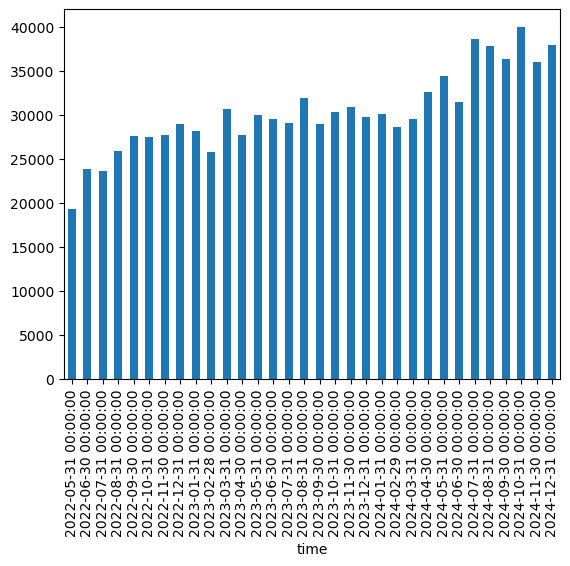

In [293]:
df[['time', 'target']].groupby(pd.Grouper(key='time', freq='ME')).target.count().plot.bar()

<Axes: xlabel='time'>

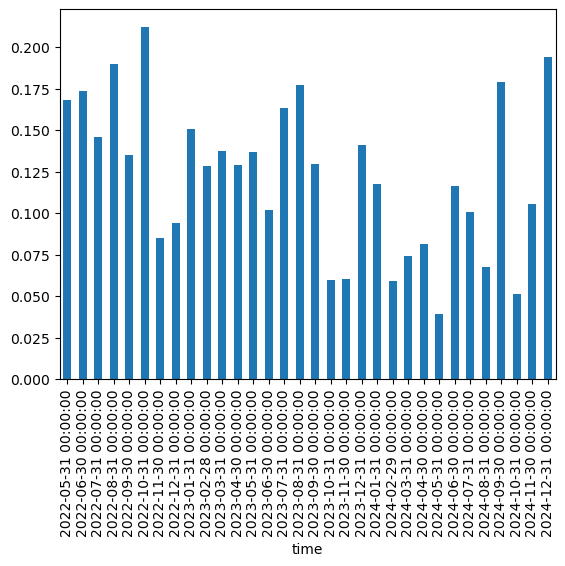

In [294]:
df[['time', 'target']].groupby(pd.Grouper(key='time', freq='ME')).target.mean().plot.bar()

<Axes: xlabel='time'>

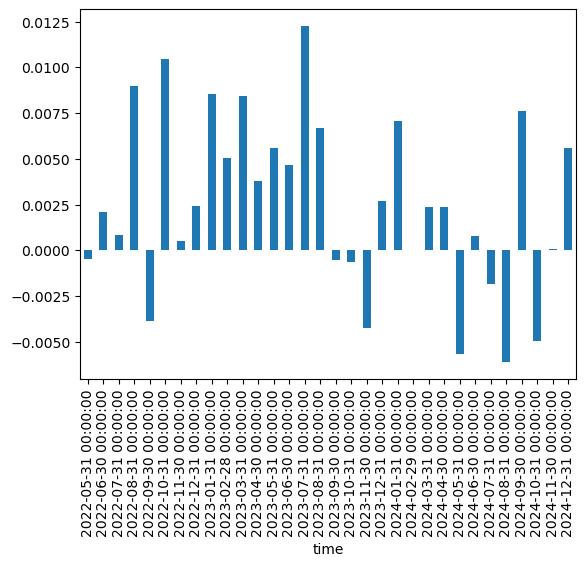

In [295]:
(df[['time', 'income_rate']].groupby(pd.Grouper(key='time', freq='ME')).income_rate.mean()-1).plot.bar()

In [300]:
mask_train = np.array((pd.Timestamp('2022-01-01') <= df['time']) & (df['time'] < pd.Timestamp('2024-07-01')))
mask_valid = np.array((pd.Timestamp('2024-07-01') <= df['time']) & (df['time'] < pd.Timestamp('2024-09-01')))
mask_test = np.array((pd.Timestamp('2024-09-01') <= df['time']) & (df['time'] < pd.Timestamp('2024-11-01')))
mask_test2 = np.array((pd.Timestamp('2024-11-01') <= df['time']) & (df['time'] < pd.Timestamp('2024-12-23')))
#mask_test2 = mask_test

In [302]:
mask_train.sum(), mask_valid.sum(), mask_test.sum(), mask_test2.sum()

(744713, 76495, 76398, 61912)

In [321]:
# некоторые акции имеют более короткую историю
NEED_POINTS = 102
mask_avbl_all = np.zeros_like(mask_train).astype(bool)
for ticker in df["ticker"].unique():
    mask = np.array(df['ticker'] == ticker)
    count_days = df.loc[mask, 'time'].dt.date.nunique()
    if count_days < NEED_POINTS:
        mask_avbl = np.zeros_like(mask_train).astype(bool)
    else:
        date_first_avbl =  np.sort(df.loc[mask, 'time'].dt.date.unique())[NEED_POINTS]
        #print(date_first_avbl)
        mask_avbl = np.array(df["time"] >= pd.to_datetime(date_first_avbl))
    
    mask_ticker = np.array(df['ticker'] == ticker)
    mask_avbl_ticker = mask_ticker & mask_avbl

    mask_avbl_all |= mask_avbl_ticker

mask_train &= mask_avbl_all
mask_valid &= mask_avbl_all
mask_test &= mask_avbl_all
mask_test2 &= mask_avbl_all


#мб дату неправильно обрезаю

In [322]:
mask_train.sum(), mask_valid.sum(), mask_test.sum(), mask_test2.sum()

(627417, 76495, 76398, 61912)

In [323]:
mask_data = mask_train|mask_valid|mask_test|mask_test2
(mask_data).sum()

842222

In [324]:
df.loc[mask_data].isnull().sum()[df.loc[mask_data].isnull().sum() > 0].sort_values()

Series([], dtype: int64)

In [330]:
mask_train.sum()/(mask_data).sum(), mask_valid.sum()/(mask_data).sum(), mask_test.sum()/(mask_data).sum(), mask_test2.sum()/(mask_data).sum()

(0.7449544181937778,
 0.09082522185362055,
 0.0907100503192745,
 0.07351030963332708)

In [331]:
df.loc[mask_train, 'target'].mean(), df.loc[mask_valid, 'target'].mean(), df.loc[mask_test, 'target'].mean(), df.loc[mask_test2, 'target'].mean()

(0.11392423220920057,
 0.08411007255376168,
 0.11197937118772743,
 0.14310634448895207)

In [332]:
df.loc[mask_train, 'income_rate'].mean(), df.loc[mask_valid, 'income_rate'].mean(), df.loc[mask_test, 'income_rate'].mean(), df.loc[mask_test2, 'income_rate'].mean()

(1.0033340002554012,
 0.9960423901944401,
 1.0010175784246673,
 1.0012733586015665)

In [334]:
#проверки

In [340]:
(mask_train.sum()+mask_valid.sum()+mask_test.sum()+mask_test2.sum()) ==(mask_data).sum()

#(mask_train.sum()+mask_valid.sum()+mask_test.sum()) ==(mask_data).sum()

True

In [344]:
df.head()

,time,ticker,index_1day,close_w1_roc,volume_w1_roc,tmos_close_w1_roc,close_w5_norm_std,close_w5_mean_abs_pct,close_w5_alpha,close_w5_rsi,...,volume_1day_w100_min/volume_1day_w100_max,tmos_close_1day_w100_min/tmos_close_1day_w100_max,target,ticker_code,y_pred,result,delta_time,income_rate,res_price,res_ind
0,2022-05-04 18:00:00,AFLT,0.0,-0.000641,-0.110107,-0.007126,0.004979,0.004078,-8.443163,37.500000,...,1.0,1.0,0,3,None,LOSE,1 days 16:00:00,0.98,30.38,18
1,2022-05-05 10:00:00,AFLT,0.0,0.001282,1.836605,0.009569,0.002413,0.003187,-8.802817,20.000000,...,1.0,1.0,0,3,None,LOSE,1 days 00:00:00,0.98,30.38,18
2,2022-05-05 11:00:00,AFLT,0.0,-0.008323,-0.239264,-0.002370,0.003366,0.003710,-7.727273,17.241379,...,1.0,1.0,0,3,None,LOSE,1 days 01:00:00,0.98,30.28,20
3,2022-05-05 12:00:00,AFLT,0.0,-0.001937,-0.628420,0.002375,0.004823,0.002822,-9.103020,22.727272,...,1.0,1.0,0,3,None,LOSE,1 days 00:00:00,0.98,30.28,20
4,2022-05-05 13:00:00,AFLT,0.0,0.000000,-0.145421,0.002370,0.005022,0.002436,-9.046053,10.526316,...,1.0,1.0,0,3,None,LOSE,0 days 23:00:00,0.98,30.28,20


In [347]:
df_5min.reset_index(inplace=True)
df_1hour.reset_index(inplace=True)
df_1day.reset_index(inplace=True)

NameError: name 'df_5min' is not defined

In [75]:
df = df_1min.merge(df_5min, left_on='index_5min', right_on='index', how='left', suffixes=("_j1min", "_j5min"))
df = df.merge(df_1hour, left_on='index_1hour', right_on='index', how='left', suffixes=("_j5min", "_j1hour"))
df = df.merge(df_1day, left_on='index_1day', right_on='index', how='left', suffixes=("_j1hour", "_j1day"))

df.shape

(3816149, 188)

In [77]:
df.head()

,time_j1min,close,volume,ticker_j1min,index_1min_start,index_5min,index_start_5min,index_1hour,index_start_1hour,index_1day,...,close_1day_w200_min,close_1day_w200_max,close_1day_w200_rsi,volume_1day_w200_ma,volume_1day_w200_std,volume_1day_w200_min,volume_1day_w200_max,volume_1day_w200_rsi,sin_time_weekday,cos_time_weekday
0,2023-10-02 11:00:00,168.039993,860.0,GAZP,0.0,41933.0,0.0,3601.0,0.0,253.0,...,153.089996,184.389999,51.084591,2912151.75,2348000.0,524716.0,18061598.0,50.249245,-2.449294e-16,1.0
1,2023-10-02 11:01:00,168.009995,1965.0,GAZP,0.0,41933.0,0.0,3601.0,0.0,253.0,...,153.089996,184.389999,51.084591,2912151.75,2348000.0,524716.0,18061598.0,50.249245,-2.449294e-16,1.0
2,2023-10-02 11:02:00,167.990005,773.0,GAZP,0.0,41933.0,0.0,3601.0,0.0,253.0,...,153.089996,184.389999,51.084591,2912151.75,2348000.0,524716.0,18061598.0,50.249245,-2.449294e-16,1.0
3,2023-10-02 11:03:00,167.949997,3115.0,GAZP,0.0,41933.0,0.0,3601.0,0.0,253.0,...,153.089996,184.389999,51.084591,2912151.75,2348000.0,524716.0,18061598.0,50.249245,-2.449294e-16,1.0
4,2023-10-02 11:04:00,167.940002,5051.0,GAZP,0.0,41933.0,0.0,3601.0,0.0,253.0,...,153.089996,184.389999,51.084591,2912151.75,2348000.0,524716.0,18061598.0,50.249245,-2.449294e-16,1.0


In [79]:
df.isnull().sum()

time_j1min              0
close                   0
volume                  0
ticker_j1min            0
index_1min_start        0
                       ..
volume_1day_w200_min    0
volume_1day_w200_max    0
volume_1day_w200_rsi    0
sin_time_weekday        0
cos_time_weekday        0
Length: 188, dtype: int64

In [32]:
df_1min.shape, df.shape

((3816149, 49), (3816149, 188))

In [33]:
df['ticker_j1min'].notnull().sum(), df['ticker_j5min'].notnull().sum(), df['ticker_j1hour'].notnull().sum(), df['ticker_j1day'].notnull().sum(), 

(3816149, 3816149, 3816149, 3816149)

##### ticker

In [35]:
df['ticker_code'] = df['ticker_j1min'].astype('category').cat.codes

In [36]:
dict(enumerate(df['ticker_j1min'].astype('category').cat.categories))

{0: 'ALRS',
 1: 'CHMF',
 2: 'GAZP',
 3: 'GMKN',
 4: 'LKOH',
 5: 'MAGN',
 6: 'MGNT',
 7: 'MTSS',
 8: 'NLMK',
 9: 'NVTK',
 10: 'OZON',
 11: 'ROSN',
 12: 'RUAL',
 13: 'SBER',
 14: 'SNGS',
 15: 'SNGSP',
 16: 'T',
 17: 'TATN',
 18: 'YDEX'}

### 3. Model

In [349]:
df['ticker_code'] = df['ticker'].astype('category').cat.codes

In [351]:
df['ticker_code'].nunique()

127

In [353]:
df.loc[mask_train, 'ticker_code'].nunique()

127

In [355]:
df.columns.tolist()

['time',
 'ticker',
 'index_1day',
 'close_w1_roc',
 'volume_w1_roc',
 'tmos_close_w1_roc',
 'close_w5_norm_std',
 'close_w5_mean_abs_pct',
 'close_w5_alpha',
 'close_w5_rsi',
 'close_w5_roc',
 'volume_w5_norm_std',
 'volume_w5_mean_abs_pct',
 'volume_w5_alpha',
 'volume_w5_rsi',
 'volume_w5_roc',
 'tmos_close_w5_norm_std',
 'tmos_close_w5_mean_abs_pct',
 'tmos_close_w5_alpha',
 'tmos_close_w5_rsi',
 'tmos_close_w5_roc',
 'close_w14_norm_std',
 'close_w14_mean_abs_pct',
 'close_w14_alpha',
 'close_w14_rsi',
 'close_w14_roc',
 'volume_w14_norm_std',
 'volume_w14_mean_abs_pct',
 'volume_w14_alpha',
 'volume_w14_rsi',
 'volume_w14_roc',
 'tmos_close_w14_norm_std',
 'tmos_close_w14_mean_abs_pct',
 'tmos_close_w14_alpha',
 'tmos_close_w14_rsi',
 'tmos_close_w14_roc',
 'close_w70_norm_std',
 'close_w70_mean_abs_pct',
 'close_w70_alpha',
 'close_w70_rsi',
 'close_w70_roc',
 'close_w70_lvl_1-1.01',
 'close_w70_lvl_-0.99-1',
 'close_w70_lvl_1.01-1.02',
 'close_w70_lvl_-0.98-0.99',
 'close_w70_l

In [357]:
drop_cols = ['time',
             #'ticker_code',
             'hour', 'day', 'weekday', 
             'month',

 'ticker',
 'index_1day',
 'result',
 'delta_time',
 'income_rate',
 'res_price',
 'res_ind', 'index', 'target', 
              'ind', 'close',
             'y_pred'] #+ [elem for elem in df.columns if 'roc' in elem]


features = df.columns[~df.columns.isin(drop_cols)].tolist()

#features = [elem for elem in df.columns if (('/' in elem) or ('lvl' in elem) or ('alpha' in elem))] + ['ticker_code'] #+ ['hour', 'day', 'weekday']

cat_features = ['ticker_code',
                #'hour', 'day', 'weekday',# 'month'
]


target = 'target'

In [359]:
len(features)

670

In [361]:
features

['close_w1_roc',
 'volume_w1_roc',
 'tmos_close_w1_roc',
 'close_w5_norm_std',
 'close_w5_mean_abs_pct',
 'close_w5_alpha',
 'close_w5_rsi',
 'close_w5_roc',
 'volume_w5_norm_std',
 'volume_w5_mean_abs_pct',
 'volume_w5_alpha',
 'volume_w5_rsi',
 'volume_w5_roc',
 'tmos_close_w5_norm_std',
 'tmos_close_w5_mean_abs_pct',
 'tmos_close_w5_alpha',
 'tmos_close_w5_rsi',
 'tmos_close_w5_roc',
 'close_w14_norm_std',
 'close_w14_mean_abs_pct',
 'close_w14_alpha',
 'close_w14_rsi',
 'close_w14_roc',
 'volume_w14_norm_std',
 'volume_w14_mean_abs_pct',
 'volume_w14_alpha',
 'volume_w14_rsi',
 'volume_w14_roc',
 'tmos_close_w14_norm_std',
 'tmos_close_w14_mean_abs_pct',
 'tmos_close_w14_alpha',
 'tmos_close_w14_rsi',
 'tmos_close_w14_roc',
 'close_w70_norm_std',
 'close_w70_mean_abs_pct',
 'close_w70_alpha',
 'close_w70_rsi',
 'close_w70_roc',
 'close_w70_lvl_1-1.01',
 'close_w70_lvl_-0.99-1',
 'close_w70_lvl_1.01-1.02',
 'close_w70_lvl_-0.98-0.99',
 'close_w70_lvl_1.02-1.03',
 'close_w70_lvl_-0.9

In [363]:
'ticker_code' in features

True

In [366]:
D_train = lgbm.Dataset(df.loc[mask_train, features], label=df.loc[mask_train, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
D_valid = lgbm.Dataset(df.loc[mask_valid, features], label=df.loc[mask_valid, target], reference=D_train, feature_name=features, categorical_feature=cat_features, free_raw_data=False)
D_test = lgbm.Dataset(df.loc[mask_test, features], label=df.loc[mask_test, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
D_test2 = lgbm.Dataset(df.loc[mask_test2, features], label=df.loc[mask_test2, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)


D_train.income_rate = df.loc[mask_train, 'income_rate'].values
D_valid.income_rate = df.loc[mask_valid, 'income_rate'].values
D_test.income_rate = df.loc[mask_test, 'income_rate'].values
D_test2.income_rate = df.loc[mask_test2, 'income_rate'].values

In [370]:
def mean_income_rate(y_pred, data):
    q = 0.99
    mask = y_pred >= np.quantile(y_pred, q)
    score = round(data.income_rate[mask].mean(), 5)
    
    return 'mean_income_rate', score, True#is_higher_better
    

In [398]:
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    
    
    "num_boost_round" : 10_000,

    
    "num_leaves": 2,
    #"learning_rate": 0.001,
     "feature_fraction": 0.2,
     "bagging_fraction": 0.2,
     "bagging_freq": 1,
    'lambda_l1' : 1,
    'lambda_l2' : 1,
    #"verbose": 0,

    #'max_bin' : 1000000,
    
    
    #"metric": "auc",
    "metric" : 'mean_income_rate',
    "early_stopping" : 50,

    
}

model = lgbm.train(params, train_set=D_train, valid_sets=[D_valid], feval=mean_income_rate)

/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 71478, number of negative: 555939
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.064362 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 150300
[LightGBM] [Info] Number of data points in the train set: 627417, number of used features: 670
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113924 -> initscore=-2.051269
[LightGBM] [Info] Start training from score -2.051269
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	valid_0's mean_income_rate: 1.00904


In [399]:
model.num_trees()

48

In [403]:
y_pred_train = model.predict(D_train.data)
y_pred_valid = model.predict(D_valid.data)
y_pred_test = model.predict(D_test.data)
y_pred_test2 = model.predict(D_test2.data)


df["y_pred"] = None
df.loc[mask_train, 'y_pred'] = y_pred_train
df.loc[mask_valid, 'y_pred'] = y_pred_valid
df.loc[mask_test, 'y_pred'] = y_pred_test
df.loc[mask_test2, 'y_pred'] = y_pred_test2

roc_auc_score(D_train.label, y_pred_train), roc_auc_score(D_valid.label, y_pred_valid), roc_auc_score(D_test.label, y_pred_test), roc_auc_score(D_test2.label, y_pred_test2)


(0.7436915305850664,
 0.7318511012276229,
 0.7445291455873042,
 0.5809190882440993)

In [457]:
#свой threshold

q = 0.99

threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
mask = df['y_pred'] > threshold
print('\nValid')
print(df.loc[mask_valid&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_valid&mask, 'income_rate'].mean())

threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nTest')
print(df.loc[mask_test&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test&mask, 'income_rate'].mean())

threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nTest2')
print(df.loc[mask_test2&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test2&mask, 'income_rate'].mean())


Valid
result
LOSE    0.471218
WIN     0.290495
DNF     0.238286
Name: proportion, dtype: float64
1.0079605660302269

Test
result
WIN     0.450704
LOSE    0.402049
DNF     0.147247
Name: proportion, dtype: float64
1.0159457929682132

Test2
result
WIN     0.486356
LOSE    0.372392
DNF     0.141252
Name: proportion, dtype: float64
1.0197617755383377


In [461]:
df.loc[mask_valid&mask, 'delta_time'].median(), df.loc[mask_test&mask, 'delta_time'].median(), df.loc[mask_test2&mask, 'delta_time'].median()

(Timedelta('1 days 01:00:00'),
 Timedelta('1 days 01:00:00'),
 Timedelta('0 days 22:00:00'))

In [463]:
mask_win = df['result'] == 'WIN'
df.loc[mask_valid&mask&mask_win, 'delta_time'].median(), df.loc[mask_test&mask&mask_win, 'delta_time'].median(), df.loc[mask_test2&mask&mask_win, 'delta_time'].median()

(Timedelta('0 days 20:00:00'),
 Timedelta('1 days 04:00:00'),
 Timedelta('0 days 22:00:00'))

In [467]:
#общий threshold

threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
print(f'threshokd = {threshold}')

mask = df['y_pred'] >= threshold
print('\nValid')
print(df.loc[mask_valid&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_valid&mask, 'income_rate'].mean())

#threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print("\nTest")
print(df.loc[mask_test&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test&mask, 'income_rate'].mean())

#threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print('\nTetst2')
print(df.loc[mask_test2&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test2&mask, 'income_rate'].mean())

threshokd = 0.2905635832022931

Valid
result
LOSE    0.453024
WIN     0.302445
DNF     0.244530
Name: proportion, dtype: float64
1.0090354221251099

Test
result
LOSE    0.414648
WIN     0.349206
DNF     0.236146
Name: proportion, dtype: float64
1.01243608593045

Tetst2
result
LOSE    0.432707
WIN     0.407668
DNF     0.159624
Name: proportion, dtype: float64
1.0146101746192877


In [470]:
df.loc[mask_valid&mask, 'delta_time'].median(), df.loc[mask_test&mask, 'delta_time'].median(), df.loc[mask_test2&mask, 'delta_time'].median()

(Timedelta('2 days 00:00:00'),
 Timedelta('1 days 02:00:00'),
 Timedelta('1 days 01:00:00'))

In [472]:
mask_win = df['result'] == 'WIN'
df.loc[mask_valid&mask&mask_win, 'delta_time'].median(), df.loc[mask_test&mask&mask_win, 'delta_time'].median(), df.loc[mask_test2&mask&mask_win, 'delta_time'].median()

(Timedelta('1 days 11:00:00'),
 Timedelta('1 days 13:00:00'),
 Timedelta('0 days 22:00:00'))

In [476]:
(mask_valid&mask).sum(), (mask_test&mask).sum(), (mask_test2&mask).sum()

(777, 3591, 1278)

In [478]:
df.loc[mask_test2&mask, 'time'].dt.date.nunique()

18

In [480]:
df.loc[mask_test2&mask, 'ticker'].unique()

array(['KROT', 'MRKY', 'YAKG', 'RKKE', 'MRKZ', 'LNZL', 'NSVZ', 'VRSB',
       'UWGN', 'TGKN', 'ABIO', 'GTRK', 'BLNG', 'NKHP', 'TGKB', 'ROLO',
       'IRKT', 'HEAD', 'KLSB', 'MSTT', 'DVEC', 'VEON-RX', 'TGKBP', 'MRKS',
       'PRFN', 'RBCM'], dtype=object)

In [482]:
df.loc[mask_test2&mask, 'ticker'].value_counts()

ticker
TGKBP      113
BLNG       108
RBCM       107
TGKB       100
PRFN        89
VRSB        82
KROT        82
MRKY        65
MSTT        61
GTRK        55
DVEC        52
KLSB        52
NSVZ        46
RKKE        42
HEAD        42
VEON-RX     36
MRKZ        35
MRKS        25
YAKG        22
IRKT        14
LNZL        14
ABIO        14
UWGN         8
ROLO         7
TGKN         5
NKHP         2
Name: count, dtype: int64

In [486]:
s = model.feature_importance(importance_type='gain').sum()
sorted(zip(features, np.round((model.feature_importance(importance_type='gain')/s*100), 2)), key=lambda x: -x[1])

[('ticker_code', 23.98),
 ('close_w70_mean_abs_pct', 13.09),
 ('volume_1day_w100_mean_abs_pct', 9.73),
 ('close_1day_w20_mean_abs_pct', 8.29),
 ('volume_1day_w100_norm_std', 5.78),
 ('tmos_close_w70_ma_low_3std/tmos_close', 5.43),
 ('close_w70_min/close_w70_max', 5.29),
 ('volume_1day_w100_min/volume_1day_w100_max', 3.61),
 ('close_1day_w20_min/close_1day_w20_max', 2.82),
 ('close_1day_w100_lvl_1.02-1.03', 2.27),
 ('tmos_close_w70_std/tmos_close', 2.15),
 ('close_1day_w100_min/close_1day_w100_max', 1.68),
 ('tmos_close_w70_ma_low_2std/tmos_close', 1.61),
 ('tmos_close_1day_w100_alpha', 1.6),
 ('close/close_w70_min', 1.44),
 ('close_1day_w100_lvl_1.04-1.05', 1.37),
 ('close_1day_w20_norm_std', 1.29),
 ('tmos_close_1day_w100_roc', 1.08),
 ('tmos_close_1day_w5_roc/tmos_close_1day_w100_roc', 0.93),
 ('close_1day_w3_ma/close_1day_w100_ma', 0.83),
 ('close_1day_w100_lvl_1.01-1.02', 0.79),
 ('tmos_close_1day_w3_min/tmos_close_1day_w100_min', 0.77),
 ('tmos_close_1day_w3_roc/tmos_close_1day_w1

# Best

In [492]:
top = []
for elem in zip(features, np.round((model.feature_importance(importance_type='gain')/s*100), 2)):
    if elem[1] > 0: 
        top += [elem[0]]
top

['close_w70_mean_abs_pct',
 'close/close_w70_min',
 'tmos_close_w5_ma_low_3std/tmos_close',
 'tmos_close_w70_std/tmos_close',
 'tmos_close_w70_ma_low_2std/tmos_close',
 'tmos_close_w70_ma_low_3std/tmos_close',
 'close_w70_min/close_w70_max',
 'close_1day_w20_norm_std',
 'close_1day_w20_mean_abs_pct',
 'close_1day_w100_lvl_1.01-1.02',
 'close_1day_w100_lvl_1.02-1.03',
 'close_1day_w100_lvl_1.04-1.05',
 'close_1day_w100_lvl_1.05-1.07',
 'volume_1day_w100_norm_std',
 'volume_1day_w100_mean_abs_pct',
 'tmos_close_1day_w100_alpha',
 'tmos_close_1day_w100_roc',
 'tmos_close_1day_w100_lvl_1-1.01',
 'tmos_close_1day_w100_lvl_-0.9299999999999999-0.95',
 'tmos_close_1day_w3_roc/tmos_close_1day_w100_roc',
 'tmos_close_1day_w5_roc/tmos_close_1day_w100_roc',
 'close_1day_w3_ma/close_1day_w100_ma',
 'tmos_close_1day_w3_min/tmos_close_1day_w100_min',
 'tmos_close_1day/tmos_close_1day_w20_max',
 'close_1day_w20_min/close_1day_w20_max',
 'close_1day_w100_min/close_1day_w100_max',
 'volume_1day_w100_min

In [494]:
top_cat = ['ticker_code']

In [496]:
D_train = lgbm.Dataset(df.loc[mask_train, top], label=df.loc[mask_train, target], feature_name=top, categorical_feature=top_cat, free_raw_data=False)
D_valid = lgbm.Dataset(df.loc[mask_valid, top], label=df.loc[mask_valid, target], feature_name=top, categorical_feature=top_cat, free_raw_data=False)
D_test = lgbm.Dataset(df.loc[mask_test, top], label=df.loc[mask_test, target], feature_name=top, categorical_feature=top_cat, free_raw_data=False)
D_test2 = lgbm.Dataset(df.loc[mask_test2, top], label=df.loc[mask_test2, target], feature_name=top, categorical_feature=top_cat, free_raw_data=False)



In [506]:
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    
    
    "num_boost_round" : 10_000,

    
    "num_leaves": 2,
    #"learning_rate": 0.001,
     "feature_fraction": 0.7,
     "bagging_fraction": 0.2,
     "bagging_freq": 1,
     'lambda_l1' : 1,
     'lambda_l2' : 1,
    #"verbose": 0,

    #'max_bin' : 1000000,
    
    
    "metric": "auc",
    #"metric" : 'mean_income_rate',
    "early_stopping" : 20,

    
}

model = lgbm.train(params, train_set=D_train, valid_sets=[D_valid])

/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 71478, number of negative: 555939
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005791 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5698
[LightGBM] [Info] Number of data points in the train set: 627417, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113924 -> initscore=-2.051269
[LightGBM] [Info] Start training from score -2.051269
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[64]	valid_0's auc: 0.738174


In [508]:
model.num_trees()

64

In [510]:
y_pred_train = model.predict(D_train.data)
y_pred_valid = model.predict(D_valid.data)
y_pred_test = model.predict(D_test.data)
y_pred_test2 = model.predict(D_test2.data)


df["y_pred"] = None
df.loc[mask_train, 'y_pred'] = y_pred_train
df.loc[mask_valid, 'y_pred'] = y_pred_valid
df.loc[mask_test, 'y_pred'] = y_pred_test
df.loc[mask_test2, 'y_pred'] = y_pred_test2

roc_auc_score(D_train.label, y_pred_train), roc_auc_score(D_valid.label, y_pred_valid), roc_auc_score(D_test.label, y_pred_test), roc_auc_score(D_test2.label, y_pred_test2)


(0.7496361198355592,
 0.7381742856818715,
 0.7350169138146533,
 0.5706859056806823)

In [514]:
#свой threshold

q = 0.99

threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
mask = df['y_pred'] > threshold
print('\nValid')
print(df.loc[mask_valid&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_valid&mask, 'income_rate'].mean())

threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=q)
mask = df['y_pred'] > threshold
print('\nTest')
print(df.loc[mask_test&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test&mask, 'income_rate'].mean())

threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=q)
mask = df['y_pred'] > threshold
print('\nTest2')
print(df.loc[mask_test2&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test2&mask, 'income_rate'].mean())


Valid
result
LOSE    0.559790
WIN     0.245729
DNF     0.194481
Name: proportion, dtype: float64
1.003769925996189

Test
result
WIN     0.584946
LOSE    0.329032
DNF     0.086022
Name: proportion, dtype: float64
1.0240448285281523

Test2
result
WIN     0.487013
LOSE    0.383117
DNF     0.129870
Name: proportion, dtype: float64
1.0193085948346159


In [516]:
df.loc[mask_valid&mask, 'delta_time'].median(), df.loc[mask_test&mask, 'delta_time'].median(), df.loc[mask_test2&mask, 'delta_time'].median()

(Timedelta('2 days 12:00:00'),
 Timedelta('1 days 00:00:00'),
 Timedelta('0 days 22:00:00'))

In [518]:
mask_win = df['result'] == 'WIN'
df.loc[mask_valid&mask&mask_win, 'delta_time'].median(), df.loc[mask_test&mask&mask_win, 'delta_time'].median(), df.loc[mask_test2&mask&mask_win, 'delta_time'].median()

(Timedelta('3 days 13:00:00'),
 Timedelta('1 days 01:00:00'),
 Timedelta('0 days 21:00:00'))

In [520]:
#общий threshold

threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
print(f'threshokd = {threshold}')

mask = df['y_pred'] > threshold
print('\nValid')
print(df.loc[mask_valid&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_valid&mask, 'income_rate'].mean())

#threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print("\nTest")
print(df.loc[mask_test&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test&mask, 'income_rate'].mean())

#threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print('\nTetst2')
print(df.loc[mask_test2&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test2&mask, 'income_rate'].mean())

threshokd = 0.3321142685859895

Valid
result
LOSE    0.559790
WIN     0.245729
DNF     0.194481
Name: proportion, dtype: float64
1.003769925996189

Test
result
LOSE    0.418665
WIN     0.345647
DNF     0.235688
Name: proportion, dtype: float64
1.01225421942157

Tetst2
result
LOSE    0.418421
WIN     0.390526
DNF     0.191053
Name: proportion, dtype: float64
1.0148739794899309


In [400]:
# Valid
# result
# LOSE    0.549275
# WIN     0.446377
# DNF     0.004348
# Name: proportion, dtype: float64
# 1.0059333

# Test
# result
# WIN     0.506438
# DNF     0.309013
# LOSE    0.184549
# Name: proportion, dtype: float64
# 1.0209203

# Tetst2
# result
# WIN     0.476562
# LOSE    0.390625
# DNF     0.132812
# Name: proportion, dtype: float64
# 1.0141798

In [402]:
df.loc[mask_valid&mask, 'delta_time'].median(), df.loc[mask_test&mask, 'delta_time'].median(), df.loc[mask_test2&mask, 'delta_time'].median()

(Timedelta('2 days 03:00:00'),
 Timedelta('1 days 01:00:00'),
 Timedelta('0 days 21:00:00'))

In [404]:
mask_win = df['result'] == 'WIN'
df.loc[mask_valid&mask&mask_win, 'delta_time'].median(), df.loc[mask_test&mask&mask_win, 'delta_time'].median(), df.loc[mask_test2&mask&mask_win, 'delta_time'].median()

(Timedelta('0 days 21:00:00'),
 Timedelta('1 days 02:00:00'),
 Timedelta('0 days 21:00:00'))

In [408]:
(mask_valid&mask).sum(), (mask_test&mask).sum(), (mask_test2&mask).sum()

(763, 4385, 1869)

In [410]:
df.loc[mask_test2&mask, 'time'].dt.date.nunique()

17

In [412]:
df.loc[mask_test2&mask, 'ticker'].unique()

array(['MVID', 'SPBE', 'MTLRP', 'SFIN', 'KMAZ', 'FEES', 'FESH', 'KROT',
       'VKCO', 'MRKY', 'SELG', 'CHMK', 'YAKG', 'PMSBP', 'RKKE', 'LSRG',
       'MRKZ', 'BANE', 'CNTL', 'PMSB', 'KRKNP', 'NMTP', 'AFKS', 'UNKL',
       'APTK', 'LNZL', 'NSVZ', 'LIFE', 'RNFT', 'VRSB', 'YDEX', 'UWGN',
       'TGKN', 'ABRD', 'ABIO', 'WUSH', 'GTRK', 'CNTLP', 'BLNG', 'LSNG',
       'TRNFP', 'NKHP', 'TGKB', 'ROLO', 'IRKT', 'MGTSP', 'MTLR', 'TGKA',
       'HEAD', 'MRKV', 'KLSB', 'MSTT', 'KAZTP', 'DVEC', 'RASP', 'TTLK',
       'AMEZ', 'MRKU', 'TRMK', 'VEON-RX', 'SMLT', 'LNZLP', 'MRKC', 'MRKP',
       'UNAC', 'ELFV', 'FLOT', 'PIKK', 'SVAV', 'TGKBP', 'POSI', 'KZOS',
       'MRKS', 'PRFN', 'BSPB', 'RBCM'], dtype=object)

In [414]:
df.loc[mask_test2&mask, 'ticker'].value_counts()

ticker
TGKBP    95
RBCM     89
TGKB     87
BLNG     84
MRKZ     75
         ..
SFIN      1
TGKA      1
MRKV      1
BSPB      1
TRNFP     1
Name: count, Length: 76, dtype: int64